In [18]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import structural_similarity as ssim

from aggmap import AggMap
from aggmap.utils.matrixopt import smartpadding
import aggmap

sns.set(style = 'white', font_scale=1.5)

warnings.filterwarnings("ignore")

from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm

def get_graph_v(embd):
    '''
    Get the graph in low dimension
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))        
    return graph_v

def get_graph_u(embd):
    '''
    Get the graph in high dimension
    '''
    return embd.graph_.toarray()

def cross_entropy_via_scipy(gu, gv):
        ''' SEE: https://en.wikipedia.org/wiki/Cross_entropy'''
        return  entropy(gu) + entropy(gu, gv)
    
def get_loss_pcc_from_embd(embd):
    gv = get_graph_v(embd)
    np.fill_diagonal(gv,0)
    gv = squareform(gv)
    gu = get_graph_u(embd)
    gu = squareform(gu)
    l1 = pd.Series(gu).to_frame(name = 'y_true')
    l2 = pd.Series(gv).to_frame(name = 'y_pred')
    pcc = l1.join(l2).corr().iloc[0].iloc[1]
    loss = cross_entropy_via_scipy(gu, gv)
    return loss, pcc

In [197]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #
label_dict = {'0': 'T-shirt/top',
              '1': 'Trouser',
              '2': 'Pullover', 
              '3': 'Dress', 
              '4': 'Coat', 
              '5': 'Sandal', 
              '6': 'Shirt', 
              '7': 'Sneaker', 
              '8': 'Bag', 
              '9': 'Ankle boot'}

label_idx = pd.Series(y_train).to_frame(name='label').groupby('label').apply(lambda x:x.index.tolist())

select_class = 3

x_train = x_train[label_idx.loc[select_class]]

n, w, h = x_train.shape
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)


label_idx

label
0    [1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88...
1    [3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, ...
2    [5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 14...
3    [7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 10...
4    [2, 9, 20, 26, 53, 58, 60, 61, 64, 89, 92, 115...
5    [0, 11, 35, 47, 65, 100, 132, 138, 145, 173, 1...
6    [13, 18, 32, 36, 39, 62, 66, 73, 83, 90, 93, 1...
7    [15, 29, 38, 42, 52, 71, 79, 84, 91, 96, 101, ...
8    [17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144...
9    [4, 19, 22, 33, 43, 45, 48, 54, 57, 80, 87, 11...
dtype: object

In [198]:
shuffled_cols = shuffle(orignal_cols, random_state=111)
x_train_df_shuffled = x_train_df[shuffled_cols]
x_shuffled = x_train_df_shuffled.values.reshape(-1, 28,28)

In [199]:
mp = AggMap(x_train_df_shuffled, metric='correlation')

2021-09-12 12:28:36,953 - INFO - [bidd-aggmap] - Calculating distance ...
2021-09-12 12:28:36,986 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:00<00:00, 1114.48it/s]


In [232]:
mp = mp.fit(emb_method='umap', cluster_channels=1, var_thr=1, learning_rate=0.1, init= 'random')    

2021-09-12 12:31:36,677 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='random', learning_rate=0.1,
     local_connectivity=1.0, low_memory=True, metric='precomputed',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=32,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sun Sep 12 12:31:36 2021 Finding Nearest Neighbors
Sun Sep 12 12:31:36 2021 Finished Nearest Neighbor Search
Sun Sep 12 12:31:36 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	comple

In [233]:
mp.plot_scatter()

2021-09-12 12:31:38,391 - INFO - [bidd-aggmap] - generate file: ./feature points_555_correlation_umap_scatter
2021-09-12 12:31:38,403 - INFO - [bidd-aggmap] - save html file to ./feature points_555_correlation_umap_scatter


In [234]:
x_res = mp.batch_transform(x_train_df_shuffled.values, scale=False)

100%|##########| 6131/6131 [00:01<00:00, 3093.30it/s]


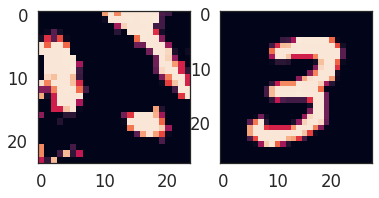

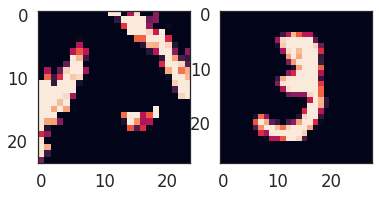

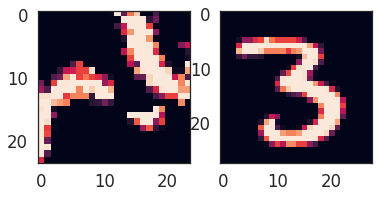

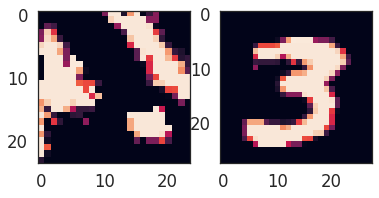

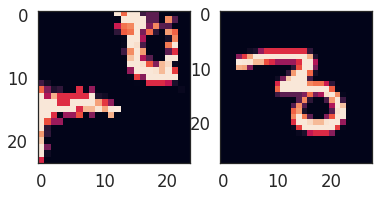

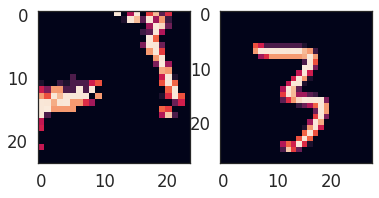

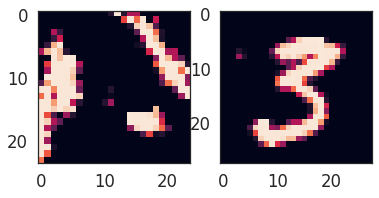

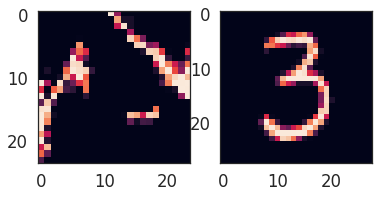

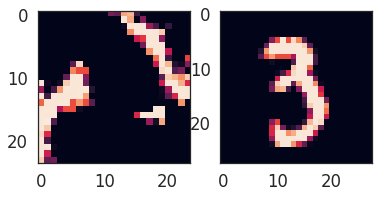

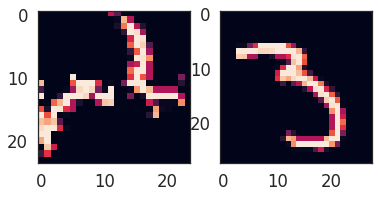

In [235]:
for i in range(10):
    fig, axes = plt.subplots(ncols=2)
    
    ax1, ax2 = axes
    ax1.imshow(x_res[i].reshape(mp.fmap_shape))
    
    ax2.imshow(x_train[i])